##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
importlib.reload(Dense)
importlib.reload(RSTF)

%matplotlib notebook
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from ipywidgets import FloatProgress
from IPython.display import display
import os

from keras.models import model_from_json
import ReadStandardTimeFill as RSTF
# pool.close()

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
def TTV_Split(iteration,Memory,X,y,params,X_fill):
    if params['Save']['Model']==True:
        params['Save']['Weights'] = True
    params['seed'] = int(iteration%params['splits_per_mod']/params['splits_per_mod']*100)
    params['iteration'] = int(iteration/params['splits_per_mod'])
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=params['seed'])
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=params['seed'])
    return(Dense.Train_Steps(params,X_train,X_test,X_val,y_train,y_test,
        y_val,X_fill = X_fill,Memory=Memory),
        y_val,params)

def RunReps(Model,params,Runs,RST):
#     RST = RSTF.ReadStandardTimeFill(params['Dpath']+'ECData.csv',CombineKeys=['Combined',
#                                   ['Shrub','Grass','Sparse','Water']])
#     RST.Master = RST.Master.loc[(RST.Master['fco2']>=0)&(RST.Master['PPFD_Avg']<=50)]
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    RMSE = []
    RST.Scale(params['Y'],Model)
    y = RST.y*1.0
#     plt.figure()
#     plt.scatter(RST.Master['wind_speed'],RST.Master['fco2']*1e-6 * 44.0095 *3600)
    X = RST.X*1.0
    X_fill = RST.X_fill*1.0
    Yval = []
    y_val= []
    for i in range(params['K']):
        results = TTV_Split(i,Memory,X,y,params,X_fill)
        Yfill = RST.YScaled.inverse_transform(results[0][0].reshape(-1,1))
        Yval = RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
        y_val = RST.YScaled.inverse_transform(results[1].reshape(-1,1))
        Runs['RMSE'].iloc[i] = metrics.mean_squared_error(y_val,Yval)
        Runs['R2'].iloc[i] = metrics.r2_score(y_val,Yval)
        params=results[2]
        Runs['iteration'].iloc[i] = params['iteration']
        Runs['seed'].iloc[i] = params['seed']
    return(Runs)

def Load_Model(params):
    json_file = open(params['Dpath']+'/'+params['Y']+'/Weights/'+params['Model']+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    return(loaded_model)
def Load_Weights(loaded_model,i,s):
    loaded_model.load_weights(params['Dpath']+'/'+params['Y']+'/Weights/'+params['Model']+'_'+str(i)+'_'+str(s)+'.h5')
    loaded_model.compile(loss='mean_squared_error', optimizer='adam')
#     print("Loaded model from disk")
    return(loaded_model)
# print(Model)## Allows for calculation of partial derivatives & Mapping a over one dimension by fixing all other dimensions
def Fix(RST,params,Vars,d,Fixed_Vals,fixall=True,n=50):
    di = [i for i,x in enumerate(Vars) if x == d]
    RST.Scale(params['Y'],Vars)
    y = RST.y*1.0
    X = RST.X*1.0
    Fixers = RST.XScaled.transform([Fixed_Vals])
    if fixall == True:
        dx = X[:,di]
        X[:,:]=Fixers
        X[:,di]=dx
        Xnu = np.zeros((n,X.shape[1]))
        dx = np.linspace(X[:,di].min(),X[:,di].max(),n)[:,np.newaxis]
        Xnu[:,:]=Fixers
        Xnu[:,di]=dx
    else:
        Xnu = RST.X_fill*1.0
        Xnu[:,di]=Fixers[:,di]
    return(Xnu,RST)

def Deriv(RST,Var,n=50):
    X = np.linspace(RST.Master[Var].min(),RST.Master[Var].max(),n)
    dx = np.diff(X)
    X = RST.XScaled.transform(X.reshape(-1,1))
    return(X,dx)

def Map_Single(ax,X,dx,RST,params):
    EmptyModel = Load_Model(params)
    y=[]
    for i,s in zip(Runs['iteration'],Runs['seed']):
        Model = Load_Weights(EmptyModel,i,s)
        Yfill=RST.YScaled.inverse_transform(Model.predict(X).reshape(-1,1))
        y.append(Yfill)
    y = np.asanyarray(y).mean(axis=0)
    X = RST.XScaled.inverse_transform(X.reshape(-1,1))
    ax[0].plot(X,y,c='red',linewidth=3,label='Modeled')
    ax[0].scatter(RST.Master[params['Vars']].values,RST.Master[params['Y']].values,c='black',label = 'Observed')
    dy_dx = np.diff(y[:,0])/dx
    ax[1].plot(X[:-1],dy_dx,c='red',linewidth=3)
    ax[0].grid()
    ax[1].grid()
    ax[0].legend()
    return(ax,y.max())

## Modeling PPFD Response

35
Saved model to disk


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


<IPython.core.display.Javascript object>


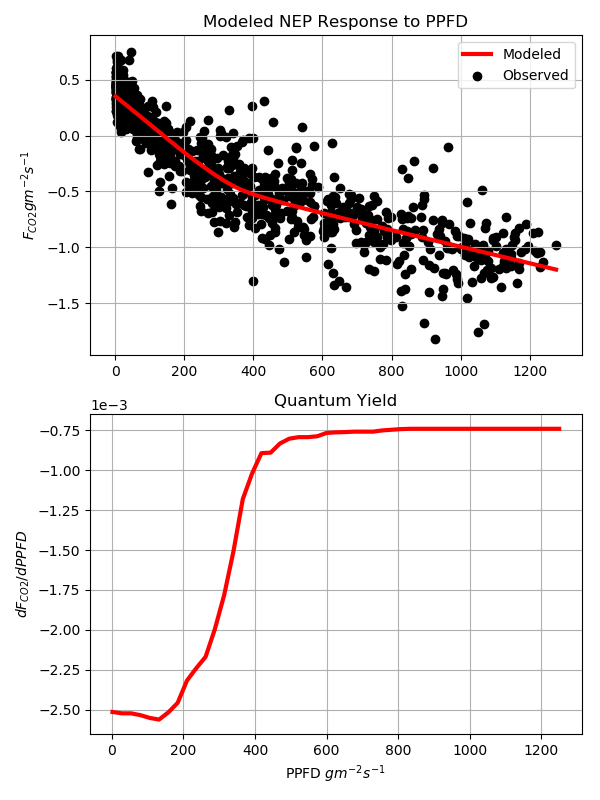

0.16446849149788367
0.35062438 0.22831886908928245


In [7]:
FillVar = 'fco2'
Site = 'Illisarvik'
Vars = ['H', 'wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'VPD', 'VWC', 'Sedge']#
Vars = ['PPFD_Avg']
# Vars = ['H', 'wind_speed', 'air_pressure', 'VPD', 'Temp', 'VWC', 'Sedge', 'Shrub', 'Out_of_Basin']
    

cwd = os.getcwd()
Runs,params = Dense.Params('Test',FillVar,MP=False)
params['Dpath'] = cwd+'/'+Site+'/'
RST = RSTF.ReadStandardTimeFill(params['Dpath']+'ECData.csv',CombineKeys=['Combined',
                                      ['Shrub','Grass','Sparse','Water']])
RST.Scale(params['Y'],Vars)

N = int(RST.Master[params['Y']].shape[0]*.8/30)
print(N)
Runs['iteration'] = 0
Runs['seed'] = 0
params['Dpath']=os.getcwd()+'/'+Site+'/'

params['N'] = N
params['Save']['Model'] = True
params['Vars']=Vars
params['Model'] = '+'.join(Vars)

Runs = Runs.iloc[0:params['K']].drop('Model',axis=1)
Runs['N'] = params['N']
Runs = RunReps(Vars,params,Runs,RST)

fig,ax = plt.subplots(2,1,figsize = (6,8))



X,dx = Deriv(RST,Vars)
ax,yMax = Map_Single(ax,X,dx,RST,params)
ax[0].set_ylabel('$F_{CO2} g m^{-2} s^{-1}$')
ax[0].set_title('Modeled NEP Response to PPFD')
ax[1].set_ylabel('$dF_{CO2}/dPPFD$')
ax[1].set_xlabel('PPFD $g m^{-2} s^{-1}$')
ax[1].set_title('Quantum Yield')
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.savefig('Figure3.png',dpi=300)
print(Runs['RMSE'].mean()**.5)
print(yMax,Runs['RMSE'].mean()**.5/(params['K']**.5)*stats.t.ppf(1-0.025,params['K']))

35
Saved model to disk


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


<IPython.core.display.Javascript object>


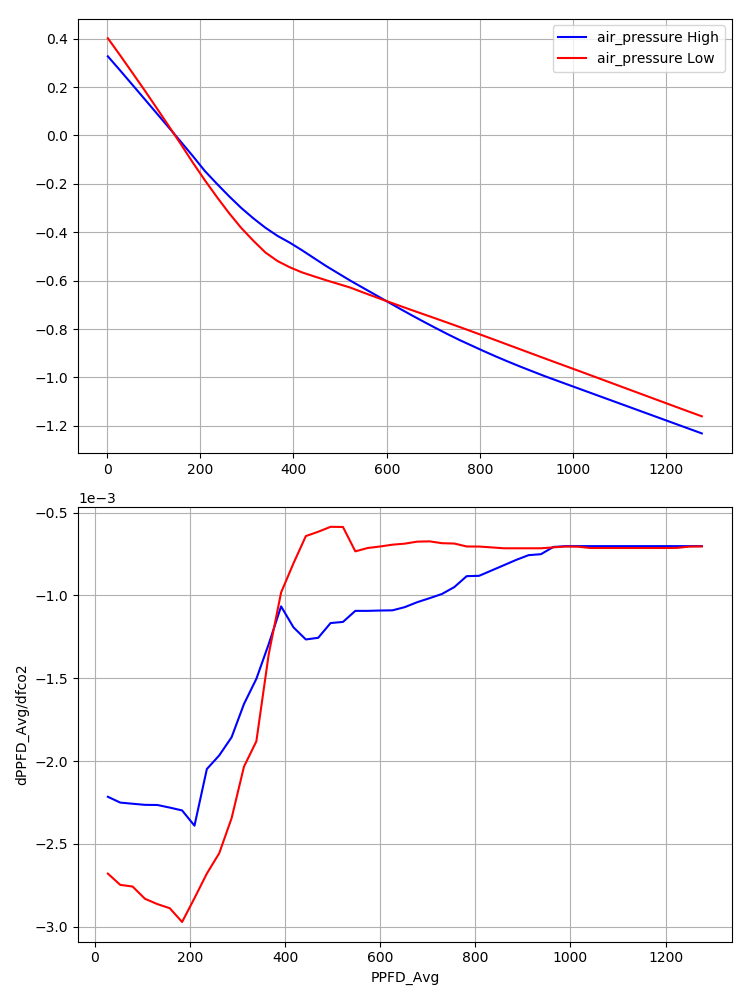

0.3271248 0.21692890824356367
0.401866 0.21692890824356367


In [12]:
FillVar = 'fco2'
Site = 'Illisarvik'
Vars = ['H', 'wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'VPD', 'VWC', 'Sedge']#
Vars = ['PPFD_Avg','air_pressure']
# Vars = ['H', 'wind_speed', 'air_pressure', 'VPD', 'Temp', 'VWC', 'Sedge', 'Shrub', 'Out_of_Basin']
    
cwd = os.getcwd()
Runs,params = Dense.Params('Test',FillVar,MP=False)
params['Dpath'] = cwd+'/'+Site+'/'
RST = RSTF.ReadStandardTimeFill(params['Dpath']+'ECData.csv',CombineKeys=['Combined',
                                      ['Shrub','Grass','Sparse','Water']])
RST.Scale(params['Y'],Vars)

N = int(RST.Master[params['Y']].shape[0]*.8/30)
print(N)
Runs['iteration'] = 0
Runs['seed'] = 0
params['Dpath']=os.getcwd()+'/'+Site+'/'

params['N'] = N
params['Save']['Model'] = True
params['Vars']=Vars
params['Model'] = '+'.join(Vars)

Runs = Runs.iloc[0:params['K']].drop('Model',axis=1)
Runs['N'] = params['N']
Runs = RunReps(Vars,params,Runs,RST)

# from matplotlib.mlab import griddata
def Map_Multiple(X,dx,params,Runs,ax,color,label,RST):
    EmptyModel = Load_Model(params)
    results = []
    for i,s in zip(Runs['iteration'],Runs['seed']):
        Model = Load_Weights(EmptyModel,i,s) 
        Yfill=RST.YScaled.inverse_transform(Model.predict(X).reshape(-1,1))
        results.append(Yfill)
    y = np.asanyarray(results).mean(axis=0)    
#     results = RST.YScaled.inverse_transform(results.reshape(-1,1))
    X = RST.XScaled.inverse_transform(X)
    data = pd.DataFrame(X,columns=Vars)
    data['Pred']=y
    
    ax[0].plot(data[dx],data['Pred'],color=color,label=label)
    data = data.sort_values(by=dx)
    data = data.groupby(dx).mean().reset_index()
    data['d'+params['Y']+'/d'+dx]=(data['Pred'].diff()/data[dx].diff())
    ax[1].plot(data[dx],data['d'+params['Y']+'/d'+dx],(),color=color)
    return(ax,data['Pred'].max())
    
if Site == 'FishIsland':
    dx = 'Wind Spd'
else:
    dx = 'PPFD_Avg'

Var = 'air_pressure'
fig,ax = plt.subplots(2,1,figsize = (7.5,10))

Fixed_Vals = RST.Master[Vars].mean()
Fixed_Vals[Var]=RST.Master[Var].quantile(.75)
X,RST=Fix(RST,params,Vars,dx,Fixed_Vals.values)
ax,yMax=Map_Multiple(X,dx,params,Runs,ax,color='blue',label=Var+' High',RST=RST)

# print(Runs['RMSE'].mean()**.5)
print(yMax,Runs['RMSE'].mean()**.5/(params['K']**.5)*stats.t.ppf(1-0.025,params['K']))

Fixed_Vals = RST.Master[Vars].mean()#quantile(.25)
Fixed_Vals[Var]=RST.Master[Var].quantile(.25)
X,RST=Fix(RST,params,Vars,dx,Fixed_Vals.values)
ax,yMax=Map_Multiple(X,dx,params,Runs,ax,color='red',label=Var+' Low',RST=RST)

# print(Runs['RMSE'].mean()**.5)
print(yMax,Runs['RMSE'].mean()**.5/(params['K']**.5)*stats.t.ppf(1-0.025,params['K']))
ax[0].grid()

ax[1].set_xlabel(dx)
ax[1].set_ylabel('d'+dx+'/d'+params['Y'])
ax[1].grid()
ax[0].legend()
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.savefig('Figure3.png',dpi=300)